In [1]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import seaborn as sns

from project.object import Object
from project.tests import Tests
from project.botma import TMA

from scipy.stats import norm
import matplotlib.pyplot as plt
import time
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
tests = Tests('test4')
print("Время последнего моделирования:", datetime.now().strftime("%d/%m/%Y %H:%M"))

# Создаем наблюдателя
observer_x, observer_y, observer_course, observer_velocity = 0.0, 0.0, 0.0, 3.0
observer = Object(
    "Наблюдатель",
    observer_x,
    observer_y,
    observer_course,
    observer_velocity,
    verbose=True,
)

# Моделирование траектории наблюдателя
observer.forward_movement(3 * 60)
observer.change_course(270, 'left', omega=0.5)
observer.forward_movement(5 * 60)
observer.change_course(90, 'right', omega=0.5)
observer.forward_movement(3 * 60)

# Создаем объект
target_bearing, target_distance, target_course, target_velocity = 0.0, 20.0, 45.0, 10.0
target = Object(
    "Объект",
    target_bearing,
    target_distance,
    target_course,
    target_velocity,
    observer,
    mode="bdcv",
    verbose=True,
)

target.forward_movement(len(observer.coords[0]) - 1)

Время последнего моделирования: 05/04/2021 06:59
Наблюдатель движется прямо по курсу 0.0° 180с
Наблюдатель перешёл на курс 270.0° за 180с
Наблюдатель движется прямо по курсу 270.0° 300с
Наблюдатель перешёл на курс 90.0° за 360с
Наблюдатель движется прямо по курсу 90.0° 180с
Объект движется прямо по курсу 45.0° 1200с


In [3]:
p0 = [0., 25., 90., 7.]
end_time_arr = range(600, 1200+1, 200)

Расчетное время = 600, Рэф = 0.3333333333333333


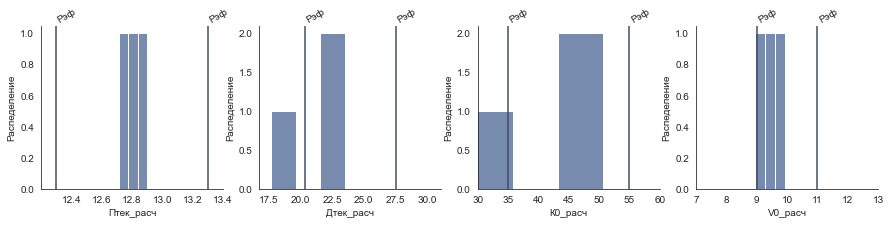

Расчетное время = 800, Рэф = 0.6666666666666666


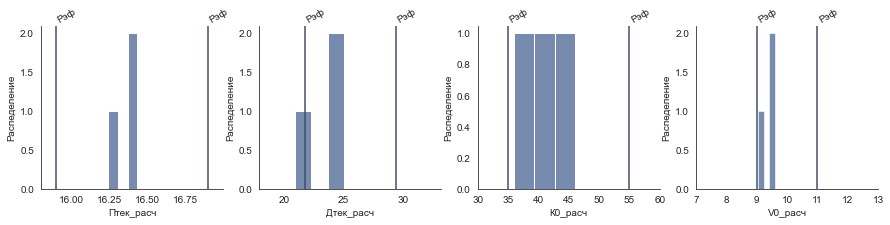

Расчетное время = 1000, Рэф = 1.0


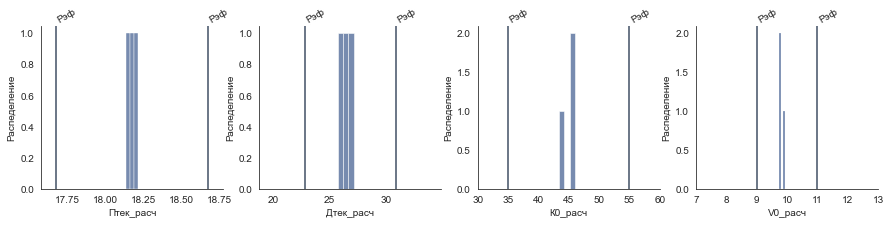

Расчетное время = 1200, Рэф = 1.0


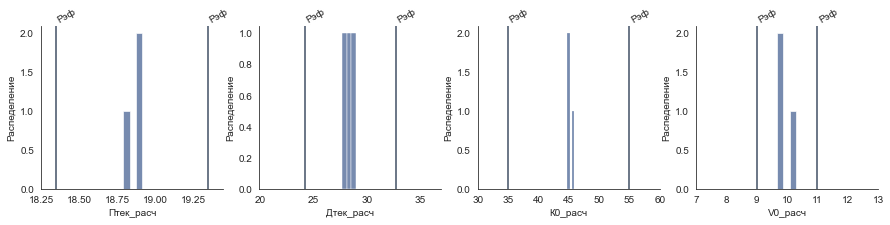

In [4]:
sns.set_style("white")
for end_time in end_time_arr:
    tma = TMA(observer, target, end_t=end_time, noise_std=np.radians(0.3))
    dict_results = tma.swarm(n=3, p0=p0, seeded=True, fixed_target=True)
    df = tests.get_df(dict_results)
    b_c = df.loc[1, 'Птек_ист']
    d_c = df.loc[1, 'Дтек_ист']
    sc1 = [b_c - 0.5, d_c * 0.85, 45 - 10, 10 * 0.9]
    sc2 = [b_c + 0.5, d_c * 1.15, 45 + 10, 10 * 1.1]
    xlim1 = [b_c - 0.6, d_c * 0.7, 45 - 15, 10 * 0.7]
    xlim2 = [b_c + 0.6, d_c * 1.3, 45 + 15, 10 * 1.3]
    fig, ax = plt.subplots(1, 4, figsize = (15, 3))
    columns = ['Птек_расч', 'Дтек_расч', 'К0_расч', 'V0_расч']
    for i, col in enumerate(columns):
        ax[i].set(xlim=(xlim1[i], xlim2[i]))
        sns.histplot(df[col], ax=ax[i], color="#496595");
        ax[i].axvline(x=sc1[i], color="#3f4d63")
        ax[i].axvline(x=sc2[i], color="#3f4d63")
        ax[i].text(sc1[i], ax[i].get_ylim()[1] * 1.02, 'Рэф', rotation=30)
        ax[i].text(sc2[i], ax[i].get_ylim()[1] * 1.02, 'Рэф', rotation=30)
        ax[i].set_ylabel('Распеделение')
        sns.despine()

    print('Расчетное время = {}, Рэф = {}'.format(end_time, df['Успех'].apply(lambda x: x[2]).mean(axis=0)))
    plt.show();

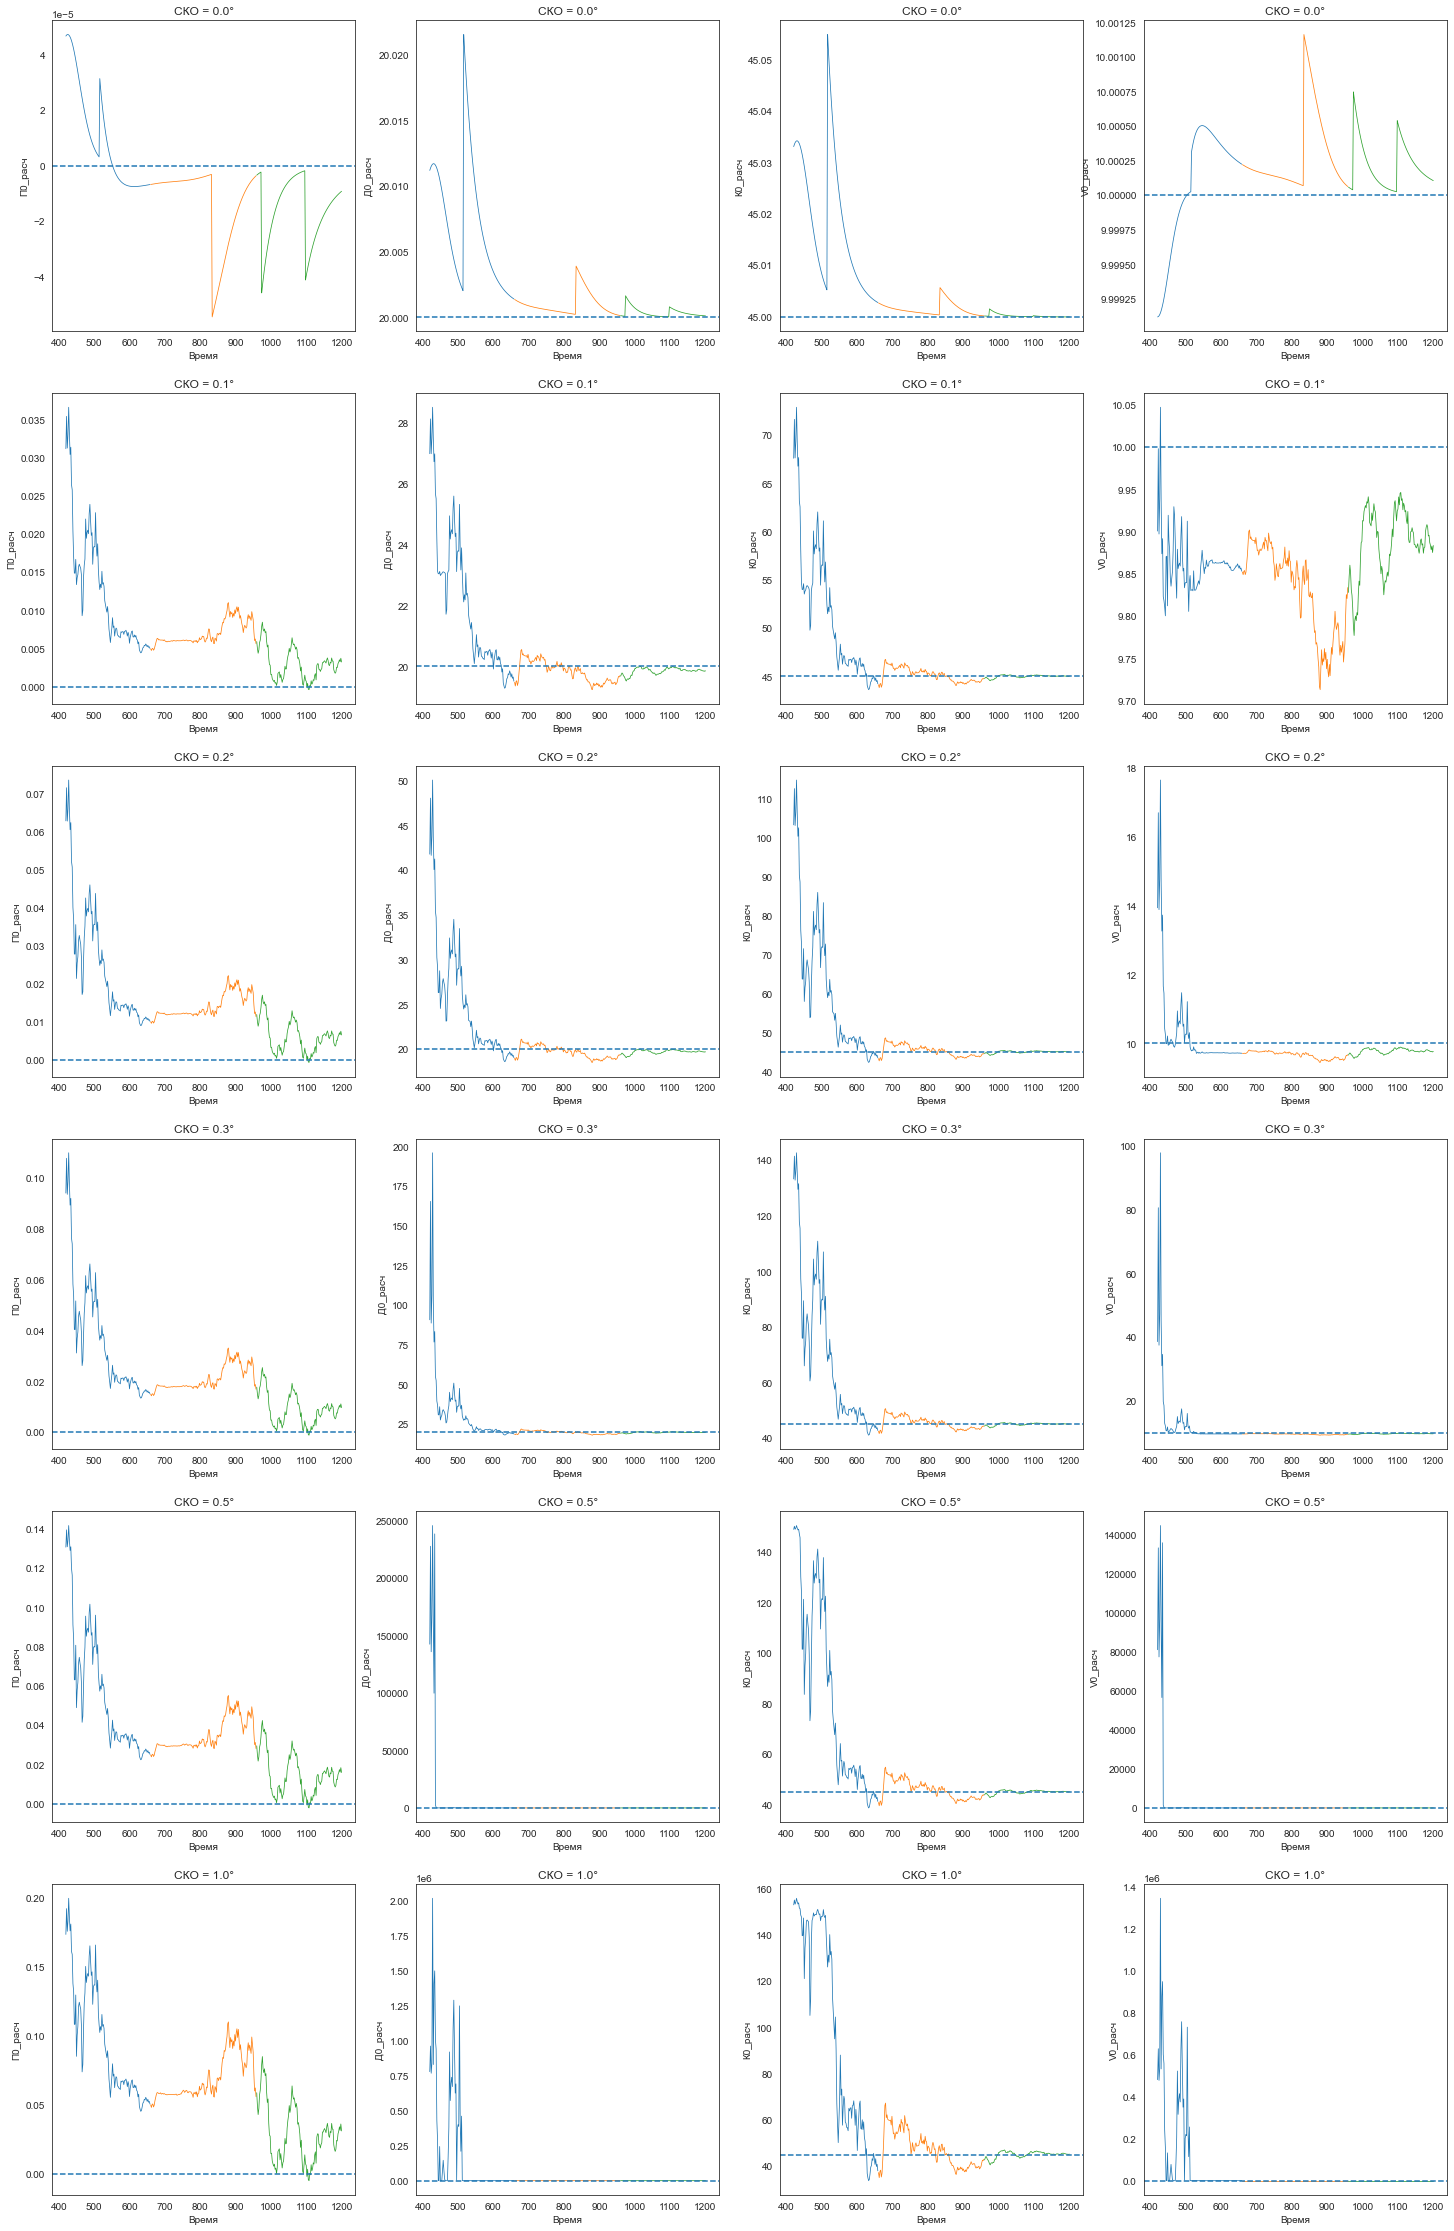

In [5]:
start_t = 420
tau = 2
end_t = len(observer.coords[0]) - 1
t = range(start_t, end_t + 1, tau)
columns = ['П0_расч', 'Д0_расч', 'К0_расч', 'V0_расч']
std_arr = [0., 0.1, 0.2, 0.3, 0.5, 1.]
fig, ax = plt.subplots(6, 4, figsize=(25, 40))
for i, std in enumerate(std_arr):
    tma = TMA(observer, target, noise_std=np.radians(std), seed=1, tau=tau)
    r = tma.real_time_process([0., 25., 7., 0.], start_t, tau)
    df = tests.get_df(r)
    df['П0_расч'] = df['П0_расч'].apply(lambda x: x - 360 if x > 180 else x)
    v = [0., 20., 45., 10.]
    for j, col in enumerate(columns):
        sns.lineplot(x=t[:120], y=df[col][:120], ax=ax[i, j], size=0.2, legend=False);
        sns.lineplot(x=t[120:270], y=df[col][120:270], ax=ax[i, j], size=0.2, legend=False);
        sns.lineplot(x=t[270:], y=df[col][270:], ax=ax[i, j], size=0.2, legend=False);
        ax[i, j].axhline(v[j], linestyle='--', linewidth=1.5)
        ax[i, j].set_xlabel('Время')
        ax[i, j].set_title('CКО = {}°'.format(std))
        ax[i, j].ticklabel_format(useOffset=False)